# Libaries and Packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from collections import defaultdict

"""
    Math Plot Library Configs
"""

%matplotlib inline
mpl.style.use('seaborn')
mpl.rcParams["figure.facecolor"] ='#f6f5f5'

"""
    Pandas Configs
"""

# show all columns
pd.set_option('max_columns', None)

# show all rows
pd.set_option("max_rows", None)

# Whether to print out the full DataFrame repr for wide DataFrames across multiple lines, 
# max_columns is still respected, but the output will wrap-around across multiple “pages” 
# if it’s width exceeds display.width. [default: True] [currently: True]
pd.set_option('display.expand_frame_repr', False)


"""
    Seaborn Configs
"""
sns.set_palette("pastel")

# Notebook Setup
Load CSV into Panda Dataframe, and clean up data

In [2]:
raw = pd.read_csv('../adult_data.csv', index_col=False, skipinitialspace=True)

print('Raw Data Shape:',raw.shape)
print()
raw.info()
display(raw.describe())
display(raw.head())

Raw Data Shape: (32561, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               32561 non-null  int64 
 1   work class        32561 non-null  object
 2   final weight      32561 non-null  int64 
 3   education         32561 non-null  object
 4   education number  32561 non-null  int64 
 5   marital status    32561 non-null  object
 6   occupation        32561 non-null  object
 7   relationship      32561 non-null  object
 8   race              32561 non-null  object
 9   sex               32561 non-null  object
 10  capital gain      32561 non-null  int64 
 11  capital loss      32561 non-null  int64 
 12  hours per week    32561 non-null  int64 
 13  native country    32561 non-null  object
 14  target            32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,final weight,education number,capital gain,capital loss,hours per week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


,age,work class,final weight,education,education number,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,native country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
raw_test = pd.read_csv('../adult_test.csv', index_col=False, skipinitialspace=True)

print('Test Raw Data Shape:', raw_test.shape)
print()
raw_test.info()
display(raw_test.describe())
display(raw_test.head())

Test Raw Data Shape: (16281, 15)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               16281 non-null  int64 
 1   work class        16281 non-null  object
 2   final weight      16281 non-null  int64 
 3   education         16281 non-null  object
 4   education number  16281 non-null  int64 
 5   marital status    16281 non-null  object
 6   occupation        16281 non-null  object
 7   relationship      16281 non-null  object
 8   race              16281 non-null  object
 9   sex               16281 non-null  object
 10  capital gain      16281 non-null  int64 
 11  capital loss      16281 non-null  int64 
 12  hours per week    16281 non-null  int64 
 13  native country    16281 non-null  object
 14  target            16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


,age,final weight,education number,capital gain,capital loss,hours per week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


,age,work class,final weight,education,education number,marital status,occupation,relationship,race,sex,capital gain,capital loss,hours per week,native country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


# Data Cleaning

In [4]:
df = raw.copy(deep=True)

TARGET_COLUMN = pd.Index(['target'])
CAT_COLUMNS = raw.select_dtypes(exclude=np.number).columns.drop(TARGET_COLUMN)
CON_COLUMNS = raw.select_dtypes(include=np.number).columns

print("Target Column:")
display(TARGET_COLUMN)
print()

Target Column:


Index(['target'], dtype='object')

## Categorical Columns
It seems like some of the `Native Country` column has a bit of typos and misclassification. Let us fix that in advance.

In [5]:
print("Categorical Columns:")
display(CAT_COLUMNS)
print()


print('Catagorical Column\'s Values\n')
for col in df.select_dtypes(exclude=np.number).columns:
    unique = raw[col].unique()
    print('-'*7,f'columns {col}','-'*7)
    print(f'There are {len(unique)} Unique values')
    print(f'They are: {unique}\n')

Categorical Columns:


Index(['work class', 'education', 'marital status', 'occupation',
       'relationship', 'race', 'sex', 'native country'],
      dtype='object')


Catagorical Column's Values

------- columns work class -------
There are 9 Unique values
They are: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

------- columns education -------
There are 16 Unique values
They are: ['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

------- columns marital status -------
There are 7 Unique values
They are: ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

------- columns occupation -------
There are 15 Unique values
They are: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']

------- columns relationship -

In [6]:
# replace all '?' with the word 'Unknown'
# df.replace(to_replace=['?'], value='Unknown', inplace = True)

# fix all typos in countries
df['native country'].replace(to_replace=['South'], value='South Korea', inplace=True)
df['native country'].replace(to_replace=['Hong'], value='Hong Kong', inplace=True)

# merge all 'Outlying-US(Guam-USVI-etc)' terittories together
# https://www.aacrao.org/edge/country/u.s.-territories-and-minor-outlying-islands
df['native country'].replace(to_replace=['Puerto-Rico'], value='Outlying-US(Guam-USVI-etc)', inplace=True)

# Scotland is a part of UK
df['native country'].replace(to_replace=['Scotland'], value='United-Kingdom', inplace=True)

## Continious Columns
It seems like there is no `NaN` / negative values on the numeric values.

So, it is safe to assume that we don't have to manipulate the numeric columns. 

In [7]:
print("Continious Columns:")
display(CON_COLUMNS)
print()

print(f'Does any of continious columns contain NaN:\n{df[CON_COLUMNS].isnull().values.any()}\n')
print(f'Does any of continious columns contain negative value:\n{(df[CON_COLUMNS].values < 0).any()}')

Continious Columns:


Index(['age', 'final weight', 'education number', 'capital gain',
       'capital loss', 'hours per week'],
      dtype='object')


Does any of continious columns contain NaN:
False

Does any of continious columns contain negative value:
False


# Exploratory Data Analysis (EDA) using Data Visualization

Columns:
- age: the age of the responder
- workclass: the type of work fo the responder
- final weight: the number of units in the target population that the responding unit represents.
- education: education level (in words)
- education-num: the number of years of education in total
- marital-status: self-explanatory
- occupation: self-explanatory
- relationship: the responder's role in the family
- race: self-explanatory
- sex: self-explanatory
- capital-gain: income from investmenet (other than wage / salary)
- capital-loss: loss due to investment
- hours-per-week: self-explanatory
- native-country: self-explanatory
- target: the expected prediction outcome

## Relationship Graph

In [8]:
def to_numeric(df):
    d = defaultdict(LabelEncoder)
    return df.apply(lambda x: d[x.name].fit_transform(x))

### Categorical Columns
From the heatmap below, we can conclude that:
- The responder's `sex` plays a big part in determining the `target`

Other intersting findings:
- `ocupation` and `work class` are somehow related
- `marital status` and `relationship` are tightly-knit
- `race` and `native country` are somehow related

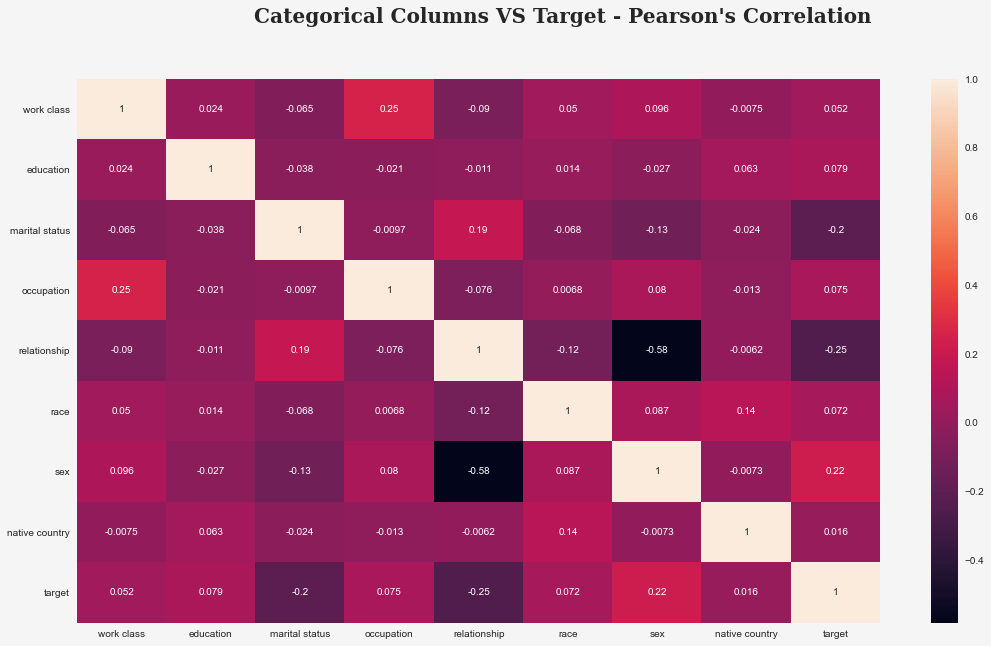

In [9]:
plt.figure(figsize=(18,10))

cat_cols = to_numeric(df[CAT_COLUMNS.append(TARGET_COLUMN)])
sns.heatmap(cat_cols.corr(),annot=True)

plt.suptitle('Categorical Columns VS Target - Pearson\'s Correlation',size=20, fontweight='bold', fontfamily='serif')
plt.show()

### Continuous Columns
From the heatmap below, we can conclude that:
- `capital gain` and `education number` are somehow co-related to `target`
- `work per hour` and `age` may be related to `target`

Other intersting findings:
- Educated folks tend to have longer `work per hour`
- Educated and older folks also have the tendency to have more `capital gain`

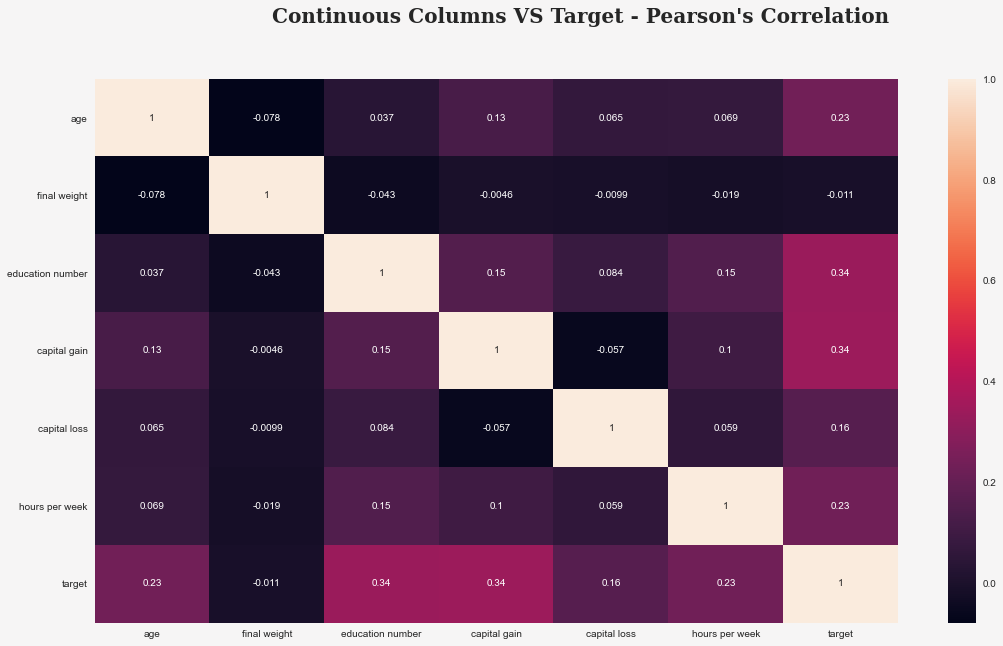

In [10]:
plt.figure(figsize=(18,10))

cat_cols = to_numeric(df[CON_COLUMNS.append(TARGET_COLUMN)])
sns.heatmap(cat_cols.corr(),annot=True)

plt.suptitle('Continuous Columns VS Target - Pearson\'s Correlation',size=20, fontweight='bold', fontfamily='serif')
plt.show()

## Distribution Graph

### Continious Column Counts

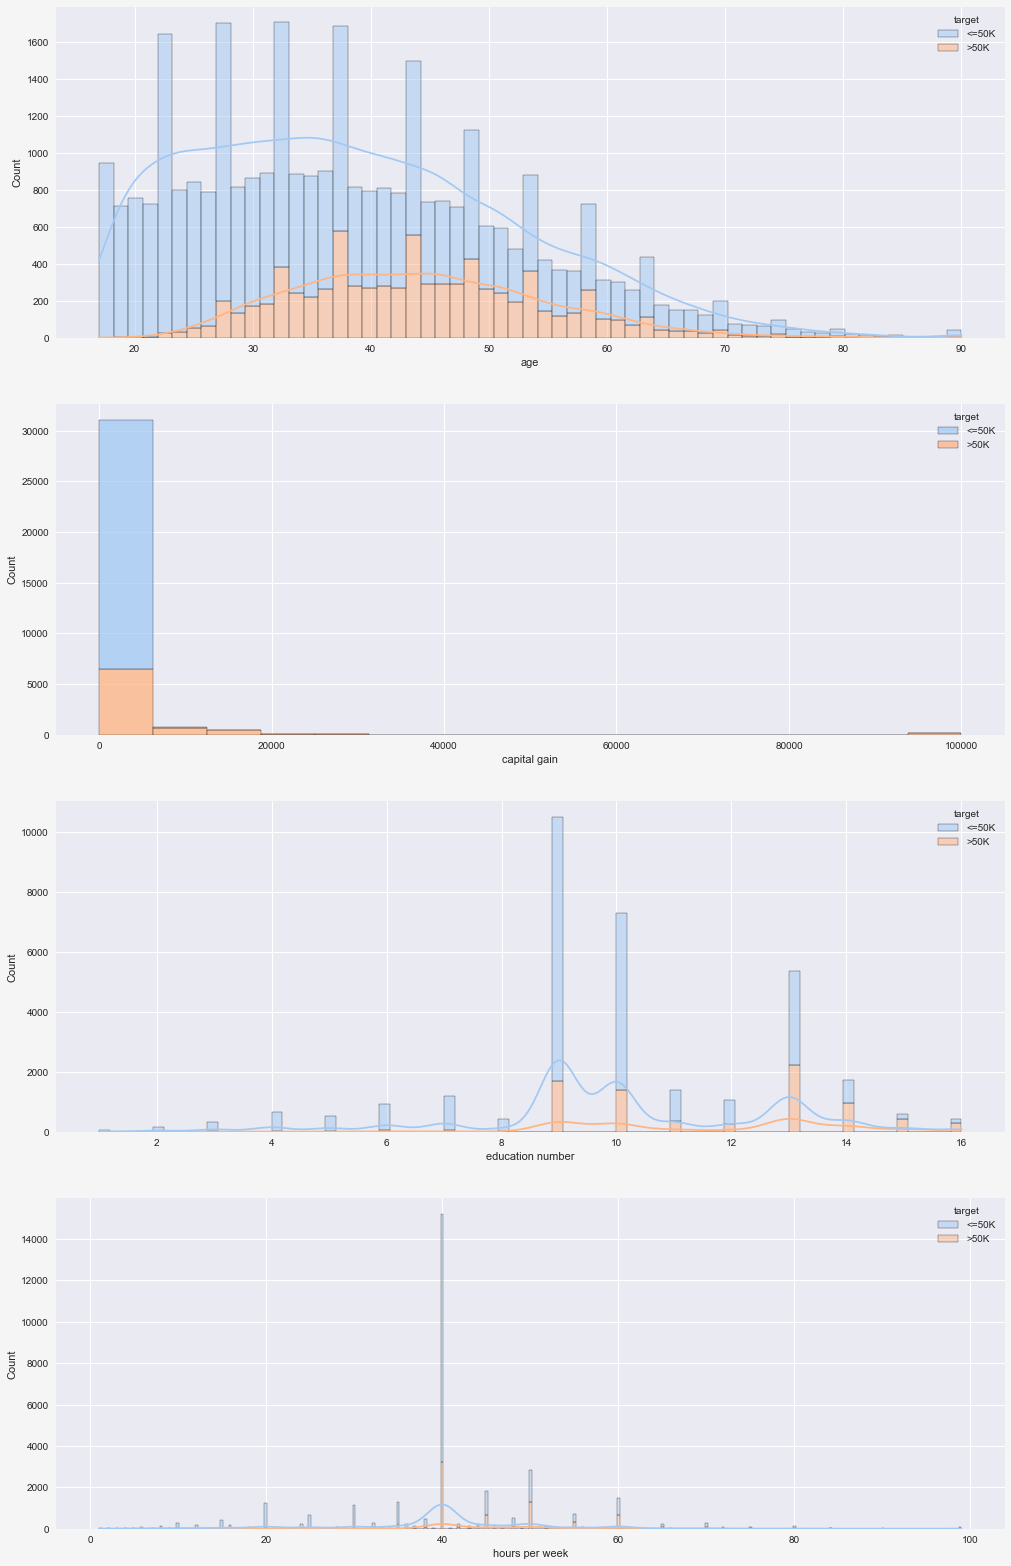

In [47]:
fig, axs = plt.subplots(4, 1, figsize=(17, 28))
sns.histplot(data=df, x="age", hue="target", multiple="stack", ax=axs[0], kde=True)
sns.histplot(data=df, x="capital gain", hue="target", multiple="stack", ax=axs[1])
sns.histplot(data=df, x="education number", hue="target", multiple="stack", ax=axs[2], kde=True)
sns.histplot(data=df, x="hours per week", hue="target", multiple="stack", ax=axs[3], kde=True)
plt.show()

From the graph above, we can draw the following conclusions:
- The age of 37 - 47 seem to be where the most `>= 50k` folks lie.
- Both of the clusters decreased significantly as the age increases.

- TODO: Elaborate more